In [18]:
import yaml

file = yaml.safe_load(open("./fight.yaml"))

In [25]:
res = []
for i,technique in enumerate(file["techniques"]):
    
    secu = len(technique["mitigations"]) + len(technique["detections"])
    secu += len(technique["preconditions"]) + len(technique["postconditions"])
    
    nb_ref = len(technique["references"])
    
    if technique["status"] == "Theoretical" and nb_ref > 0:
        res.append((secu, i))
        # print(f"[{secu}] {technique["name"]}, {nb_ref} refs")

print("Analyzing unexplored techniques (references yet status theoretical)")
print(f"{len(res)} ({int(len(res)/len(file["techniques"])*100)}%) results, avg secu {int(sum([r[0] for r in res]) / len(res))}")

print("")
print(f"{[r[0] for r in res].count(0)} ({int([r[0] for r in res].count(0)/len(file["techniques"])*100)}%) with 0 secu")
for r in res :
    if r[0] <= 0 :
        technique = file["techniques"][r[1]]
        print(f"{technique["name"]} (status {technique["status"]} with {len(technique["references"])} refs) | {technique["architecture-segment"]} | {technique["description"][:100].strip()}...")
        
print("")
print("Techniques with multiple references:")
for r in res :
    technique = file["techniques"][r[1]]
    if len(technique["references"]) > 1 and "Control Plane" in technique["architecture-segment"]:
        print(f"{technique["name"]} (status {technique["status"]} with {len(technique["references"])} refs) | {technique["architecture-segment"]} ")

Analyzing unexplored techniques (references yet status theoretical)
88 (48%) results, avg secu 6

3 (1%) with 0 secu
Stage Capabilities (status Theoretical with 1 refs) | Control Plane, RAN | Adversaries may upload, install, or otherwise set up capabilities that can be used during targeting....
Configure Operator Core Network (status Theoretical with 1 refs) | Control Plane | An adversary may operationalize a customized mobile network in a target environment to enable other...
RAN Intelligent Controller (RIC) (status Theoretical with 5 refs) | RAN, O-RAN | An adversary may compromise a RAN Intelligent Controller (RIC) to affect radio network configura...

Techniques with multiple references:
Exfiltration Over Unencrypted Non-C2 Protocol (status Theoretical with 5 refs) | Control Plane, Roaming 
Covert Exfiltration Of Data Via DNS Request (status Theoretical with 5 refs) | User Plane, Control Plane 
Compromise Hardware Supply Chain (status Theoretical with 3 refs) | Control Plane, RAN, 

In [ ]:
tact_dict = {t["id"]: [] for t in file["tactics"]}

for technique in file["techniques"]:
    
    secu = len(technique["mitigations"]) + len(technique["detections"])
    secu += len(technique["preconditions"]) + len(technique["postconditions"])
    
    for tactic in technique["tactics"]:
        tact_dict[tactic].append(secu)

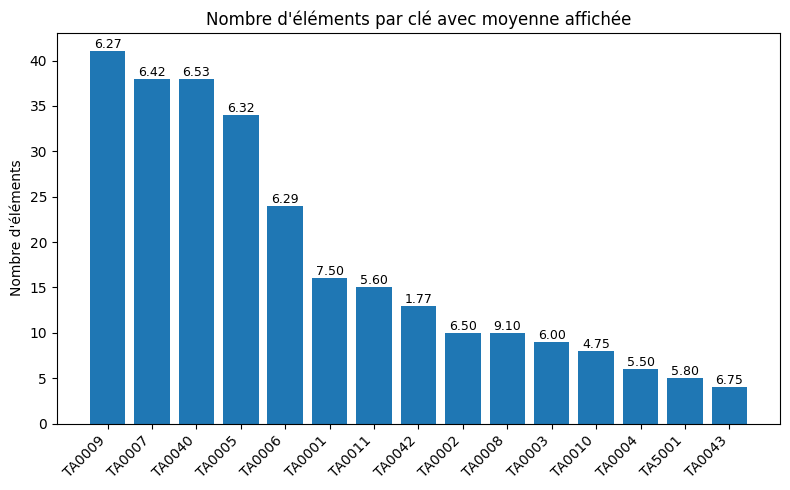

In [49]:
import matplotlib.pyplot as plt
import numpy as np

sorted_items = sorted(tact_dict.items(), key=lambda x: len(x[1]), reverse=True)

# Calcul du nombre d'éléments et de la moyenne pour chaque clé
keys = [k for k, _ in sorted_items]
counts = [len(v) for _, v in sorted_items]
means = [np.mean(v) if len(v) > 0 else 0 for _, v in sorted_items]

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(keys, counts)

# Ajouter la moyenne au-dessus de chaque barre
for bar, mean in zip(bars, means):
    ax.text(
        bar.get_x() + bar.get_width()/2,       # position x
        bar.get_height(),                      # position y
        f"{mean:.2f}",                    # texte
        ha='center', va='bottom', fontsize=9
    )

# Options esthétiques
ax.set_ylabel("Nombre d'éléments")
ax.set_title("Nombre d'éléments par clé avec moyenne affichée")

plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


In [19]:
segment_dict = {}

for technique in file["techniques"]:
    
    secu = len(technique["mitigations"]) + len(technique["detections"])
    secu += len(technique["preconditions"]) + len(technique["postconditions"])
    
    if "architecture-segment" in technique :
        segments = technique["architecture-segment"].split(", ")
        for segment in segments :
            if segment not in segment_dict :
                segment_dict[segment] = []
            segment_dict[segment].append(secu)

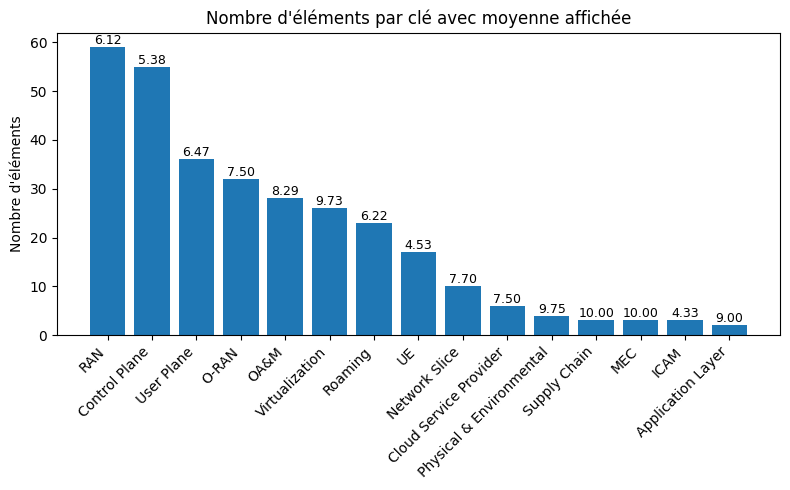

In [48]:
import matplotlib.pyplot as plt
import numpy as np

sorted_items = sorted(segment_dict.items(), key=lambda x: len(x[1]), reverse=True)

# Calcul du nombre d'éléments et de la moyenne pour chaque clé
keys = [k for k, _ in sorted_items]
counts = [len(v) for _, v in sorted_items]
means = [np.mean(v) if len(v) > 0 else 0 for _, v in sorted_items]

# Création du graphique
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(keys, counts)

# Ajouter la moyenne au-dessus de chaque barre
for bar, mean in zip(bars, means):
    ax.text(
        bar.get_x() + bar.get_width()/2,       # position x
        bar.get_height(),                      # position y
        f"{mean:.2f}",                    # texte
        ha='center', va='bottom', fontsize=9
    )

# Options esthétiques
ax.set_ylabel("Nombre d'éléments")
ax.set_title("Nombre d'éléments par clé avec moyenne affichée")

plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


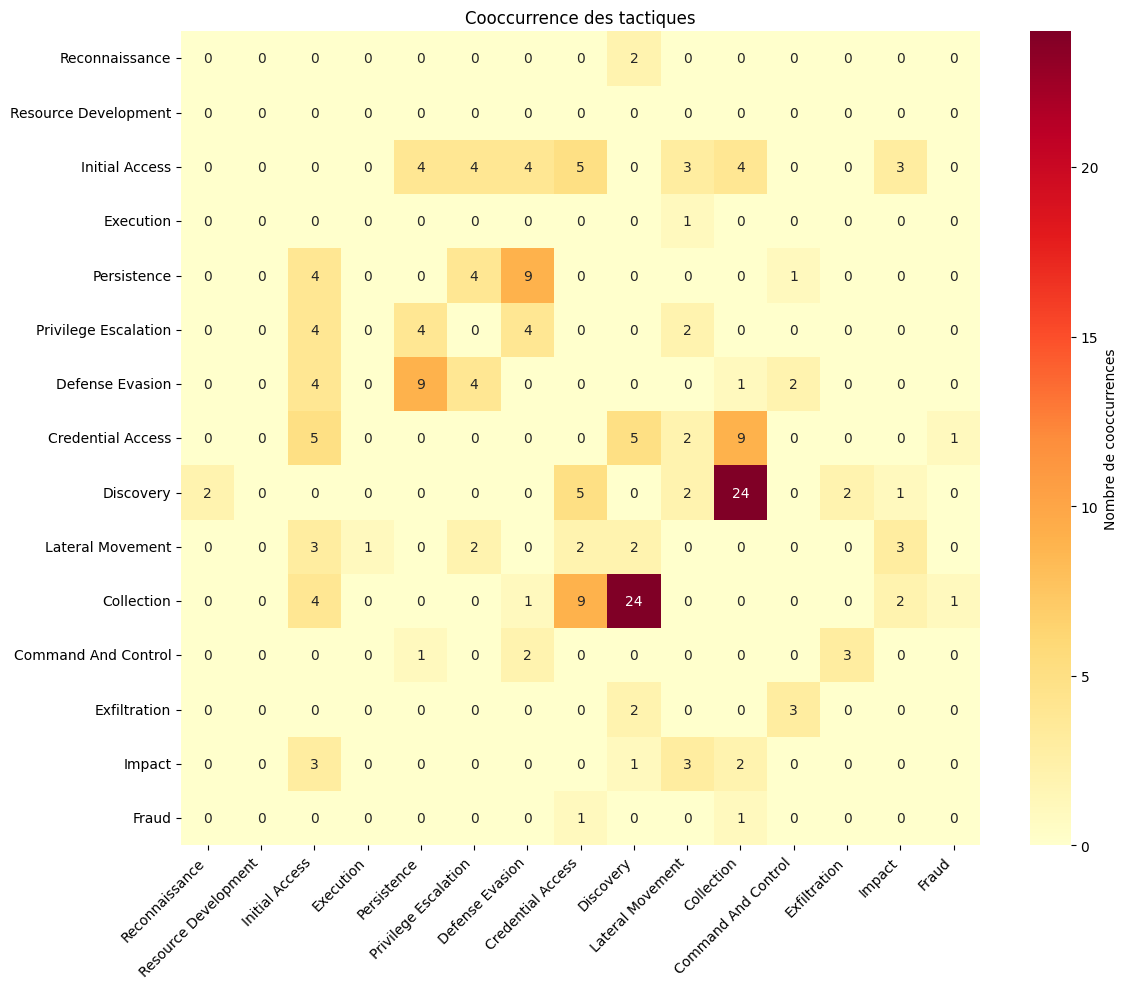

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# --- Liste de toutes les tactiques ---
all_tactics = [t["name"] for t in file["tactics"]]

# --- Initialisation de la matrice de cooccurrence ---
cooc_matrix = pd.DataFrame(0, index=all_tactics, columns=all_tactics)

# --- Remplissage de la matrice ---
for technique in file["techniques"]:
    # Récupérer les noms des tactiques pour cette technique
    tactics = []
    for tid in technique["tactics"]:
        for tactic_info in file["tactics"]:
            if tactic_info["id"] == tid:
                tactics.append(tactic_info["name"])
    
    # Incrémenter toutes les paires uniques
    for t1, t2 in itertools.combinations(tactics, 2):
        cooc_matrix.loc[t1, t2] += 1
        cooc_matrix.loc[t2, t1] += 1  # symétrique

# --- Heatmap avec Seaborn ---
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_matrix, annot=True, fmt="d", cmap="YlOrRd", cbar_kws={'label': 'Nombre de cooccurrences'})
plt.title("Cooccurrence des tactiques")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [77]:
import networkx as nx
import itertools

# Initialisation du graphe pondéré
G = nx.Graph()

# Création du dict pour les tactiques
tact_dict = {t["id"]: [] for t in file["tactics"]}

for technique in file["techniques"]:
    secu = len(technique["mitigations"]) + len(technique["detections"])
    secu += len(technique["preconditions"]) + len(technique["postconditions"])

    tactics = []
    for tid in technique["tactics"]:
        for tactic_info in file["tactics"]:
            if tactic_info["id"] == tid:
                tactics.append(tactic_info["name"])
                
    # Relier tous les nœuds de cette liste entre eux (paires uniques)
    for t1, t2 in itertools.combinations(tactics, 2):
        if G.has_edge(t1, t2):
            G[t1][t2]["weight"] += 1
        else:
            G.add_edge(t1, t2, weight=1)

In [ ]:
from pyvis.network import Network

net = Network(
    height="750px", 
    width="100%", 
    bgcolor="#ffffff", 
    font_color="black", 
    notebook=True  # si tu es dans un notebook Jupyter
)

# Rendre les nœuds et arêtes physiques (pour aération)
net.barnes_hut(gravity=-3000, central_gravity=0.1, spring_length=250, spring_strength=0.01, damping=0.9)

# Ajouter les nœuds et arêtes depuis NetworkX
for node in G.nodes():
    net.add_node(node, label=node, color="#6baed6", size=10)

for u, v, data in G.edges(data=True):
    weight = data.get("weight", 1)
    net.add_edge(u, v, value=weight, title=f"Poids: {weight}")

# Activer des options interactives
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])

# --- Génération du fichier HTML interactif ---
net.show("graph_tactiques.html")

pass

graph_tactiques.html


In [25]:
import ollama

def extract_key_words(texte):
    prompt = "Find keywords and answer just the keywords without any other text each keyword separated with each other by ','"
    prompt += " :"
    prompt += texte
    
    response = ollama.chat(model="gemma3:4b", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].split(", ")

In [ ]:
import tqdm
import json

key_words = []

# The architecture surfaces
key_words += list(segment_dict.keys())

for i, technique in enumerate(tqdm.tqdm(file["techniques"], desc="Processing techniques", unit="tech")):
    
    # Technique names
    key_words.append(technique["name"])
    key_words = [kw.lower() for kw in key_words if kw]
    
key_words = list(set(key_words))
json.dump(key_words, open("key_words_classic.json", "w"))

Processing techniques: 100%|██████████| 183/183 [00:00<00:00, 85265.23tech/s]


In [ ]:
import tqdm
import json
import re

key_words = []

for i, technique in enumerate(tqdm.tqdm(file["techniques"], desc="Processing techniques", unit="tech")):
    
    # keywords from description
    description = technique["description"]
    description = re.sub(r'https?://\S+|www\.\S+', '', description)
    key_words += extract_key_words(description)
    
    key_words = [kw.lower() for kw in key_words if kw]
    
key_words = list(set(key_words))
json.dump(key_words, open("key_words_llm.json", "w"))